# Phase III: First ML Proof of Concept
## College Admissions Exploration 

- Team
- John Rotondo, Spring Yan, Anne Hu, Evan Li

Each **project group** will submit a single **jupyter notebook** which contains:

1. (3%) The implementation (using NumPy) of your first ML model as a function call to the cleaned data
2. (2%) A discussion of the preliminary results:
   - This may include checking of assumptions, generated plots/tables, measures of fit, or other attributes of the analysis
   - It does not have to be fully correct, but as a proof of concept must demonstrate that the group is close to completing the analysis

In [3]:
from secret import key
import requests
import json
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from collections import defaultdict

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import time

## Fetching & Cleaning Data 

In [5]:
def get_pages_data(key, student_size):
    """ Gets the api response and applies filter on student size, making sure to go through all the pages of data 
    Params:
    - key = api key 
    - student_size = minimum threshold (int)
    Returns:
    A list with the api response stored """
    # Base URL for the College Scorecard API
    base_url = "https://api.data.gov/ed/collegescorecard/v1/schools"
    
    # Parameters for the API call
    params = {
        'api_key': key,
        'per_page': 100,  # Number of records per page (max is usually 100)
        'page': 0,  # Start at the first page
        f'student.size__range': f'{student_size}..',  # Filter for schools with more than 50,000 students
    }
    
    # List to store all school data
    all_schools = []
    
    # Loop through pages until there are no more results
    while True:
        # Increment the page number
        params['page'] += 1
        
        # Make the API request
        response = requests.get(base_url, params=params)
        
        # Check the response status
        if response.status_code != 200:
            print(f"Error: {response.status_code}, {response.text}")
            break
    
        # Get the JSON data
        data = response.json()
        
        # Check if there are results
        if 'results' in data and len(data['results']) > 0:
            # Append the results to the all_schools list
            all_schools.extend(data['results'])
            print(f"Retrieved {len(data['results'])} records from page {params['page']}")
        else:
            # If there are no more results, break the loop
            print(f"No more records found on page {params['page']}. Stopping.")
            break

        # ***** just added this!
        # Optional: delay to avoid API rate limits
        time.sleep(1)
    
    # Print the total number of schools retrieved
    print(f"Total schools retrieved: {len(all_schools)}")
    return all_schools

In [6]:
# load in the data 
data_dct = get_pages_data(key, 5000)

Retrieved 100 records from page 1
Retrieved 100 records from page 2
Retrieved 100 records from page 3
Retrieved 100 records from page 4
Retrieved 100 records from page 5
Retrieved 100 records from page 6
Retrieved 19 records from page 7
No more records found on page 8. Stopping.
Total schools retrieved: 619


In [7]:
def build_df(data_dct):
    """ Given the json response, gather the data in the colleges_dct and conduct cleaning/filling in missing values for 
        test scores
    """

    # initialize dictionary to store college data
    colleges_dct = defaultdict(list)

    # # gets the average SAT and ACT scores across all schools in the data set for missing values
    # overall_avg_sat = get_all_sat_scores(data_dct)
    # overall_avg_act = get_all_act_scores(data_dct)

    # loop over each "school" in the data_dct
    for i in range(len(data_dct)):
        school_data = data_dct[i]['latest']['school']
        student_data = data_dct[i]['latest']['student']
        admin_data = data_dct[i]['latest']['admissions']

        # append school data
        colleges_dct['name'].append(school_data.get('name'))
        colleges_dct['city'].append(school_data.get('city'))
        colleges_dct['state'].append(school_data.get('state'))
        colleges_dct['ownership'].append(school_data.get('ownership'))

        # append student data
        colleges_dct['size'].append(student_data.get('size'))

        # append admissions data
        colleges_dct['admin_rate'].append(admin_data.get('admission_rate', {}).get('overall'))

        # append test data 
        colleges_dct['avg_sat'].append(admin_data['sat_scores']['average']['overall'])
        colleges_dct['midpoint_act'].append(admin_data['act_scores']['midpoint']['cumulative'])

        # appends test requirement status based on integers given (0-5)
        test_requirement = admin_data.get('test_requirements')
        if test_requirement == 0:
            colleges_dct['test_requirement'].append('Not Required')
        elif test_requirement == 1:
            colleges_dct['test_requirement'].append('Required')
        elif test_requirement == 2:
            colleges_dct['test_requirement'].append('Recommended')
        elif test_requirement == 3:
            colleges_dct['test_requirement'].append('Niether Rec. or Req.')
        elif test_requirement == 4:
            colleges_dct['test_requirement'].append('Not Known')
        else:
            colleges_dct['test_requirement'].append('Considered but not Req.')

        # ---- NEED TO THINK ABOUT THIS FOR YOUR FINAL PROJECT
        # if a school does not require test scores appends average of data set ACT test scores
        midpoint_act = admin_data.get('act_scores', {}).get('midpoint', {}).get('cumulative')

    return colleges_dct

# Looking into the Fetched Data & NaN Values 

In [9]:
df = pd.DataFrame(build_df(data_dct))
df.head()

,name,city,state,ownership,size,admin_rate,avg_sat,midpoint_act,test_requirement
0,Ohlone College,Fremont,CA,1,6420,NaN,NaN,NaN,Not Required
1,Orange Coast College,Costa Mesa,CA,1,15636,NaN,NaN,NaN,Not Required
2,Oxnard College,Oxnard,CA,1,5635,NaN,NaN,NaN,Not Required
3,Palomar College,San Marcos,CA,1,15057,NaN,NaN,NaN,Not Required
4,Pasadena City College,Pasadena,CA,1,19504,NaN,NaN,NaN,Not Required


In [10]:
def get_admin_rate_for_schools(state) -> int:
    state_df = pd.DataFrame()
    state_df = df[['admin_rate', 'state']].groupby(by='state').mean()
    
    if state is None:
        print("State is None.")
    else:
        return state_df.loc[state, 'admin_rate']

def get_avg_sat_for_schools(state) -> float:
    state_df = pd.DataFrame()
    state_df = df[['avg_sat', 'state']].groupby(by='state').mean()
    
    if state is None:
        print("State is None.")
    else:
        return state_df.loc[state, 'avg_sat']
    
def get_midpoint_act_for_schools(state) -> float:
    state_df = pd.DataFrame()
    state_df = df[['midpoint_act', 'state']].groupby(by='state').mean()
    
    if state is None:
        print("State is None.")
    else:
        return state_df.loc[state, 'midpoint_act']

def fill_missing_values() -> None:
    for index, row in df.iterrows():
        if pd.isna(row['admin_rate']):
            admin = get_admin_rate_for_schools(row['state'])
            df.at[index, 'admin_rate'] = admin
        if pd.isna(row['avg_sat']):
            sat = get_avg_sat_for_schools(row['state'])
            df.at[index, 'avg_sat'] = sat
        if pd.isna(row['midpoint_act']):
            act = get_midpoint_act_for_schools(row['state'])
            df.at[index, 'midpoint_act'] = act

fill_missing_values()
df

,name,city,state,ownership,size,admin_rate,avg_sat,midpoint_act,test_requirement
0,Ohlone College,Fremont,CA,1,6420,0.663431,1443.75,32.500000,Not Required
1,Orange Coast College,Costa Mesa,CA,1,15636,0.663431,1443.75,32.500000,Not Required
2,Oxnard College,Oxnard,CA,1,5635,0.663431,1443.75,32.500000,Not Required
3,Palomar College,San Marcos,CA,1,15057,0.663431,1443.75,32.500000,Not Required
4,Pasadena City College,Pasadena,CA,1,19504,0.663431,1443.75,32.500000,Not Required
...,...,...,...,...,...,...,...,...,...
614,Clovis Community College,Fresno,CA,1,6448,0.663431,1443.75,32.500000,Not Required
615,Purdue University Global,West Lafayette,IN,1,33339,0.711200,1229.25,26.500000,Not Required
616,Purdue University Northwest,Hammond,IN,1,6083,0.728200,1055.00,23.000000,Considered but not Req.
617,Commonwealth University of Pennsylvania,Bloomsburg,PA,1,9778,0.939600,1067.00,28.272727,Considered but not Req.


In [11]:
# still wo
def get_AL_data():
    state_df = pd.DataFrame()
    df[['admin_rate', 'avg_sat', 'midpoint_act', 'state']].groupby(by='state').mean()
    
    tn_admin = state_df.loc['TN', 'admin_rate']
    fl_admin = state_df.loc['FL', 'admin_rate']
    ga_admin = state_df.loc['GA', 'admin_rate']
    ms_admin = state_df.loc['MS', 'admin_rate']
    
    tn_sat = state_df.loc['TN', 'avg_sat']
    fl_sat = state_df.loc['FL', 'avg_sat']
    ga_sat = state_df.loc['GA', 'avg_sat']
    ms_sat = state_df.loc['MS', 'avg_sat']

    tn_act = state_df.loc['TN', 'midpoint_act']
    fl_act = state_df.loc['FL', 'midpoint_act']
    ga_act = state_df.loc['GA', 'midpoint_act']
    ms_act = state_df.loc['MS', 'midpoint_act']
    
    admin = np.mean((tn_admin, fl_admin, ga_admin, ms_admin))
    sat = np.mean((tn_sat, fl_sat, ga_sat, ms_sat))
    act = np.mean((tn_act, fl_act, ga_act, ms_act))

    return admin, sat, act

def get_AZ_data():
    state_df = pd.DataFrame()
    df[['avg_sat', 'midpoint_act', 'state']].groupby(by='state').mean()
    
    ut_sat = state_df.loc['UT', 'avg_sat']
    nv_sat = state_df.loc['NV', 'avg_sat']
    nm_sat = state_df.loc['NM', 'avg_sat']

    ut_act = state_df.loc['UT', 'midpoint_act']
    nv_act = state_df.loc['NV', 'midpoint_act']
    nm_act = state_df.loc['NM', 'midpoint_act']
    
    sat = np.mean((ut_sat, nv_sat, nm_sat))
    act = np.mean((ut_act, nv_act, nm_act))
    
    return sat, act

def get_CA_data():
    state_df = pd.DataFrame()
    df[['avg_sat', 'midpoint_act', 'state']].groupby(by='state').mean()
    
    or_sat = state_df.loc['OR', 'avg_sat']
    nv_sat = state_df.loc['NV', 'avg_sat']

    or_act = state_df.loc['OR', 'midpoint_act']
    nv_act = state_df.loc['NV', 'midpoint_act']
    
    sat = np.mean((or_sat, nv_sat))
    act = np.mean((or_act, nv_act))
    
    return sat, act

def temp():
    if row['state'] == 'AL':
            admin, sat, act = get_AL_data()
            df.at[index, 'admin_rate'] = admin
            df.at[index, 'avg_sat'] = sat
            df.at[index, 'midpoint_act'] = act
    elif row['state'] == 'AZ':
        sat, act = get_AZ_data()
        df.at[index, 'avg_sat'] = sat
        df.at[index, 'midpoint_act'] = act
    elif row['state'] == 'CA':
        sat, act = get_CA_data()
        df.at[index, 'avg_sat'] = sat
        df.at[index, 'midpoint_act'] = act

## Random testing to see missing value count 

In [13]:
# --- analyze NaN value count 
nan_count = df.isna().sum()
nan_count

name                 0
city                 0
state                0
ownership            0
size                 0
admin_rate           1
avg_sat             11
midpoint_act        11
test_requirement     0
dtype: int64

In [14]:
# --- if drop the nan values
df.shape

(619, 9)

In [15]:
# --- find unqiue test requirements
set(df['test_requirement'])

# -- now check if each category has a correpsonding test 
df[['admin_rate', 'avg_sat', 'midpoint_act', 'test_requirement']].groupby(by='test_requirement').mean()

,admin_rate,avg_sat,midpoint_act
test_requirement,,,
Considered but not Req.,0.712997,1218.446501,25.990058
Niether Rec. or Req.,0.746533,1293.192553,28.042741
Not Required,0.707282,1246.422092,26.702941
Required,0.639078,1170.891892,24.378378


In [16]:
df[df['test_requirement'] == "Not Required"]

,name,city,state,ownership,size,admin_rate,avg_sat,midpoint_act,test_requirement
0,Ohlone College,Fremont,CA,1,6420,0.663431,1443.75,32.500000,Not Required
1,Orange Coast College,Costa Mesa,CA,1,15636,0.663431,1443.75,32.500000,Not Required
2,Oxnard College,Oxnard,CA,1,5635,0.663431,1443.75,32.500000,Not Required
3,Palomar College,San Marcos,CA,1,15057,0.663431,1443.75,32.500000,Not Required
4,Pasadena City College,Pasadena,CA,1,19504,0.663431,1443.75,32.500000,Not Required
...,...,...,...,...,...,...,...,...,...
611,Indiana Wesleyan University-National & Global,Marion,IN,2,5451,0.711200,1229.25,26.500000,Not Required
612,Northeast Lakeview College,Universal City,TX,1,5277,0.780317,1113.30,22.884615,Not Required
613,University of the People,Pasadena,CA,2,16253,0.663431,1443.75,32.500000,Not Required
614,Clovis Community College,Fresno,CA,1,6448,0.663431,1443.75,32.500000,Not Required


In [17]:
len(set(df['state']))

df[['admin_rate', 'avg_sat', 'midpoint_act', 'state']].groupby(by='state').mean()

,admin_rate,avg_sat,midpoint_act
state,,,
AL,NaN,NaN,NaN
AZ,0.644800,NaN,NaN
CA,0.663431,1443.750000,32.500000
CO,0.821620,1197.111111,24.777778
CT,0.613683,1291.000000,29.000000
DC,0.388175,1369.250000,30.250000
DE,0.738100,1290.000000,29.000000
FL,0.543712,1207.200000,25.400000
GA,0.725788,1145.266667,24.214286


In [18]:
ca_df = df[df['state'] == 'CA']
# print(list(ca_df['name']))

# ---- confirmed the size is over 10000, but doesn't show up when put on the 10000 filter? 
ca_df[ca_df['name'] == 'University of California-San Diego']

,name,city,state,ownership,size,admin_rate,avg_sat,midpoint_act,test_requirement


In [22]:
# ---- where is the University of Alabama? 
al_df = df[df['state'] == 'AL']
al_df
# al_df[al_df['name'] == '']

,name,city,state,ownership,size,admin_rate,avg_sat,midpoint_act,test_requirement
590,Columbia Southern University,Orange Beach,AL,3,11208,NaN,NaN,NaN,Not Required


# ML Model 
First model using own calculation = regression model

## Regression Functions

In [25]:
def add_bias_column(X):
    """
    Args:
        X (array): can be either 1-d or 2-d
    
    Returns:
        Xnew (array): the same array, but 2-d with a column of 1's in the first spot
    """
    
    # If the array is 1-d
    if len(X.shape) == 1:
        Xnew = np.column_stack([np.ones(X.shape[0]), X])
    
    # If the array is 2-d
    elif len(X.shape) == 2:
        bias_col = np.ones((X.shape[0], 1))
        Xnew = np.hstack([bias_col, X])
        
    else:
        raise ValueError("Input array must be either 1-d or 2-d")

    return Xnew

In [26]:
def line_of_best_fit(X, y):
    """ Args: 
            X (array): either 1d or 2d with the predictor values 
            y (array): 1d and corresponding response values to 'X'
        Returns: 
            m (vector): vector with the slope and intercept term of the line of best fit"""
    # first call the add_bias_column for line of best fit calculation 
    Xnew = add_bias_column(X)
    
    # get the inverse of X transpose 
    XtXinv = np.linalg.inv(np.matmul(Xnew.T, Xnew))
    
    # get the vector with the slope and intercept term
    m = np.matmul(XtXinv, np.matmul(Xnew.T, y))

    return m

In [27]:
def linreg_predict(Xnew, ynew, m):
    """ Args: 
            Xnew (array): 1d or 2d with all predictor values, not including bias term
            ynew (array): 1d with all corresponding response values to 'Xnew'
            m (array): 1d array that contains the coefficents form the line_of_best_fit function
        Returns:
            result_dict (dct): A dct with 4 key-value pairs - ypreds, resids, mse, and r2"""
    
    # add bias column 
    Xnew = add_bias_column(Xnew)

    # fetch all the calculations
    ypreds = np.matmul(Xnew, m)

    resids = ynew - ypreds
    
    mse = np.mean(resids ** 2)

    # use of sklearn built-in r2_score function 
    r2 = r2_score(ynew, ypreds)

    # set up key-value pairs in the resulting dictionary 
    result_dict = {'ypreds': ypreds,
                  'resids': resids,
                  'mse': mse,
                  'r2': r2}

    return result_dict

## Simple Linear Regression
Average SAT to predict Admission Rate 

In [53]:
# use cleaned dataframe for regression model
# drop_df = df.dropna()

# --- going to try to model without the "not required" schools 
drop_df = df[df["test_requirement"] != "Not Required"]
drop_df = drop_df.dropna()

In [59]:
# check how many schools are in the data set w/ dropping NaN values & ignoring schools that are not required
drop_df.shape

(362, 9)

In [61]:
# CROSS-FOLD VALIDATION
# ------- note: using dropped df to confirm model works, need to switch the out with cleaned_df
X_train, X_test, y_train, y_test = train_test_split(drop_df['avg_sat'], drop_df['admin_rate'], test_size=0.30, random_state=42)

# now fit model using line_of_best_fit function
m_train = line_of_best_fit(X_train, y_train)

# use test data to evaulate the model using the linreg_predict function, get "m" param from fitting the model above 
results = linreg_predict(X_test, y_test, m_train)

print(f"MSE: {results['mse']}, R^2: {results['r2']}")

MSE: 0.03260430049755907, R^2: 0.4923273669424685


In [63]:
# fit the regression model to the full data set 
m_full = line_of_best_fit(drop_df["avg_sat"], drop_df["admin_rate"])
slope = m_full[1]
intercept = m_full[0]


X = drop_df["avg_sat"]

y_pred = slope * X + intercept

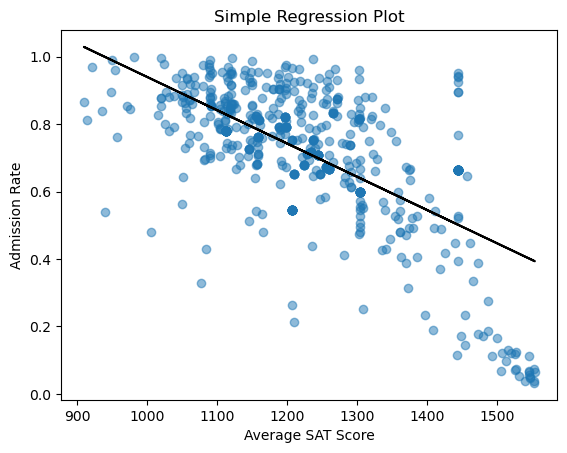

In [46]:
# --- INTIAL PLOT to see fit of the simple regression 
plt.scatter(X, drop_df["admin_rate"], label='data', alpha=0.5)

plt.plot(X, y_pred, color='black',label='linear fit')

plt.xlabel("Average SAT Score")
plt.ylabel("Admission Rate")
plt.title("Simple Regression Plot")
plt.show()

## Multiple Linear Regression
Average SAT & Midpoint ACT to predict Admission Rate 

In [65]:
# standarize the features! 

# define
x_feat_list = ['avg_sat', 'midpoint_act']
drop_df_num = drop_df[x_feat_list]

# scale the features using standardization
drop_df_scaled = pd.DataFrame()

for feat in drop_df_num.columns:
    drop_df_scaled[f'{feat}_scaled'] = ((drop_df_num[feat] - drop_df_num[feat].mean()) / drop_df_num[feat].std())

# convert dataframe to numpy array 
X_scaled = np.array(drop_df_scaled)
X_scaled[0]

array([1.49392445, 1.53533055])

In [68]:
# CROSS-FOLD VALIDATION
X_train, X_test, y_train, y_test = train_test_split(X_scaled, drop_df['admin_rate'], test_size=0.30, random_state=42)

# now fit model using line_of_best_fit function
m_multi = line_of_best_fit(X_train, y_train)

# use test data to evaulate the model using the linreg_predict function, get "m" param from fitting the model above 
multi_results = linreg_predict(X_test, y_test, m_multi)

print(f"MSE: {multi_results['mse']}, R^2: {multi_results['r2']}")

MSE: 0.03275923939212387, R^2: 0.4899148558514048


Multiple regression model produced bery similar results to the simple regression model with just average SAT!

# Dicussion of Results
- This may include checking of assumptions, generated plots/tables, measures of fit, or other attributes of the analysis
- It does not have to be fully correct, but as a proof of concept must demonstrate that the group is close to completing the analysis

## Assumptions Check

## Next Steps/Improving accuracy of the model
**note** think about maybe polynomial regression? 